In [ ]:
!git clone https://github.com/aubinbnf/Speech-Emotion-Recognition.git
%cd Speech-Emotion-Recognition
# !git branch -r
# !git switch TESS
# !git switch simon
# !git status
# !git pull TESS



Cloning into 'Speech-Emotion-Recognition'...
remote: Enumerating objects: 21809, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 21809 (delta 0), reused 3 (delta 0), pack-reused 21801 (from 1)
Receiving objects: 100% (21809/21809), 1.00 GiB | 23.58 MiB/s, done.
Resolving deltas: 100% (434/434), done.
Updating files: 100% (4955/4955), done.
/content/Speech-Emotion-Recognition


In [ ]:
%ls
%cd Speech-Emotion-Recognition



 CNN/        CNNBLSTM_ATTENTION/  'data management'/   EXTRAS_MODELS/   PARALELLECNN/         VGG/
 CNNBLSTM/   CNNLSTM_ATTENTION/    dataset/            LSTM/           'Results and plots'/
[Errno 2] No such file or directory: 'Speech-Emotion-Recognition'
/content/Speech-Emotion-Recognition


In [1]:
import tensorflow as tf
# Vérification de l'usage du GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("GPU est utilisé")
else:
    print("GPU n'est pas utilisé")


GPU est utilisé


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# prompt: importer datatset depuis drive et comme c'est un zip extraire

import zipfile
import os

# Specify the path to your zip file in Google Drive
extract_dir = "DNN/combined_dataset_spectrograms_undersampled"  # Replace with your actual path

# Specify the directory where you want to extract the contents
zip_file_path= "/content/drive/MyDrive/DNN/combined_dataset_spectrograms_undersampled.zip"  # Replace with your desired directory

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Dataset extracted successfully to {extract_dir}")
except FileNotFoundError:
    print(f"Error: Zip file not found at {zip_file_path}")
except zipfile.BadZipFile:
    print(f"Error: Invalid zip file at {zip_file_path}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Now you can access the extracted dataset files from the extract_dir
# Example:
# dataset_path = "/content/extracted_dataset/your_dataset_folder"

Dataset extracted successfully to DNN/combined_dataset_spectrograms_undersampled


In [10]:
!pip uninstall -y keras tensorflow-addons
!pip install tensorflow==2.15.0
!pip install tensorflow-addons==0.23.0
!pip install keras==2.15.0

Found existing installation: keras 3.5.0
Uninstalling keras-3.5.0:
  Successfully uninstalled keras-3.5.0
Found existing installation: tensorflow-addons 0.23.0
Uninstalling tensorflow-addons-0.23.0:
  Successfully uninstalled tensorflow-addons-0.23.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 116.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Succ

  Using cached tensorflow_addons-0.23.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.8 kB)
Using cached tensorflow_addons-0.23.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (611 kB)
^C


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import random
import gc

# ==========================
# MEMORY OPTIMIZATION
# ==========================
def clear_memory():
    """Libère la mémoire"""
    gc.collect()
    tf.keras.backend.clear_session()

# ==========================
# DATA GENERATOR WITH SPECTROGRAM-SPECIFIC AUGMENTATION
# ==========================
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_list, labels, batch_size=32, dim=(224, 224),
                 n_channels=3, n_classes=7, shuffle=True, augment=False):
        self.file_list = file_list
        self.labels = labels
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.file_list))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(len(self.file_list) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_files = [self.file_list[k] for k in indexes]
        X, y = self.__data_generation(batch_files, indexes)
        return X, y

    def __data_generation(self, batch_files, indexes):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.n_classes), dtype=int)

        for i, file_name in enumerate(batch_files):
            img = Image.open(file_name).convert("RGB").resize(self.dim)
            img_array = np.array(img) / 255.0

            if self.augment:
                img_array = self.augment_spectrogram(img_array)

            X[i,] = img_array
            y[i] = self.labels[indexes[i]]

        return X, y

    def augment_spectrogram(self, img_array):
        """Transformations spécifiques améliorées pour les spectrogrammes"""
        # Time shifting avec gestion des bords
        if np.random.rand() > 0.6:
            shift = np.random.randint(-15, 15)
            if shift > 0:
                img_array[:, shift:] = img_array[:, :-shift]
            elif shift < 0:
                img_array[:, :shift] = img_array[:, -shift:]

        # Masquage fréquentiel/temporel (SpecAugment)
        if np.random.rand() > 0.6:
            max_mask_width = 20
            mask_width = np.random.randint(5, max_mask_width)
            start = np.random.randint(0, img_array.shape[1] - mask_width)
            img_array[:, start:start+mask_width] = 0

        # Bruit gaussien adaptatif
        if np.random.rand() > 0.6:
            noise_power = np.random.uniform(0, 0.03)
            noise = np.random.normal(0, noise_power, img_array.shape)
            img_array = np.clip(img_array + noise, 0, 1)

        # Variation de contraste
        if np.random.rand() > 0.6:
            contrast_factor = np.random.uniform(0.8, 1.2)
            img_array = np.clip(img_array * contrast_factor, 0, 1)

        return img_array

# ==========================
# MODEL CREATION
# ==========================
def create_model(input_shape, num_classes):
    """Modèle avec régularisation renforcée"""
    base_model = VGG19(
        weights='imagenet',
        pooling='avg',
        include_top=False,
        input_shape=input_shape
    )

    # Gel des couches de base de manière plus agressive
    for layer in base_model.layers[:18]:  # Gel de 3 blocs supplémentaires
        layer.trainable = False

    # Configuration de régularisation
    l2_reg = tf.keras.regularizers.l2(0.03)
    dropout_rate = 0.7

    model = Sequential([
        base_model,
        Dense(128, activation='relu',
              kernel_regularizer=l2_reg,
              activity_regularizer=tf.keras.regularizers.l1(0.01)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(64, activation='relu',
              kernel_regularizer=l2_reg),
        BatchNormalization(),
        Dropout(dropout_rate + 0.1),  # Dropout progressif
        Dense(num_classes, activation='softmax')
    ])

    return model

# ==========================
# MAIN TRAINING LOOP
# ==========================
def main():
    # Configuration
    dataset_dir = "/content/DNN/combined_dataset_spectrograms_undersampled/combined_dataset_spectrograms_undersampled"
    batch_size = 32
    emotion_map = {
        "angry": 0, "sad": 1, "surprise": 2, "neutral": 3,
        "happy": 4, "fearful": 5, "disgust": 6
    }

    # Préparer les listes de fichiers et les labels
    files = []
    labels = []

    # Charger tous les fichiers
    for file_name in os.listdir(dataset_dir):
        if file_name.endswith(".png"):
            full_path = os.path.join(dataset_dir, file_name)
            emotion = file_name.split("_")[1].lower()

            if emotion in emotion_map:
                label = to_categorical(emotion_map[emotion], num_classes=len(emotion_map))
                files.append(full_path)
                labels.append(label)

    # Diviser les fichiers en train, validation et test
    train_files, temp_files, train_labels, temp_labels = train_test_split(
        files, labels, test_size=0.35, random_state=42, shuffle=True
    )

    # Diviser les fichiers temporaires en validation et test
    val_files, test_files, val_labels, test_labels = train_test_split(
        temp_files, temp_labels, test_size=0.5, random_state=42, shuffle=True
    )

    # Afficher les statistiques du dataset
    print("\nDistribution du Dataset:")
    print(f"Nombre total de fichiers: {len(files)}")
    print(f"Ensemble d'entraînement: {len(train_files)} fichiers")
    print(f"Ensemble de validation: {len(val_files)} fichiers")
    print(f"Ensemble de test: {len(test_files)} fichiers")

    # Créer les générateurs
    train_generator = DataGenerator(
        train_files, train_labels, batch_size=batch_size, shuffle=True, augment=True
    )
    val_generator = DataGenerator(
        val_files, val_labels, batch_size=batch_size, shuffle=False, augment=False
    )
    test_generator = DataGenerator(
        test_files, test_labels, batch_size=batch_size, shuffle=False, augment=False
    )

    # Clear memory and create model
    clear_memory()
    model = create_model((224, 224, 3), len(emotion_map))

    model.compile(
      optimizer=optimizers.Adam(learning_rate=1e-4, clipvalue=0.5),  # Gradient clipping
      loss="categorical_crossentropy",
      metrics=['accuracy']
  )


   # Modifications dans les callbacks
    callbacks = [
          ModelCheckpoint(
              "best_model.keras",
              monitor="val_accuracy",
              save_best_only=True,
              mode="max",
              verbose=1
          ),
          ReduceLROnPlateau(
              monitor='val_accuracy',
              patience=2,  # Réduction plus agressive
              factor=0.3,  # Réduction plus importante
              min_lr=1e-6,
              verbose=1
          ),
          EarlyStopping(
              monitor='val_accuracy',
              patience=8,  # Arrêt plus précoce
              restore_best_weights=True,
              verbose=1
          )
      ]

    class_weights = {
    0: 1,  # angry
    1: 1,  # sad
    2: 1,  # surprise
    3: 1,  # neutral
    4: 1,  # happy
    5: 1,  # fearful
    6: 1   # disgust
    }

    # Modification dans la boucle d'entraînement
    history = model.fit(
        train_generator,
        epochs=30,  # Augmentation du nombre d'epochs possible grâce à l'early stopping
        validation_data=val_generator,
        callbacks=callbacks,
        verbose=1,
        class_weight=class_weights  # Ajout des poids de classes
    )
    return history, model, test_generator, emotion_map, train_files, val_files, test_files, test_labels

# Run the main function and store the returns
history, model, test_generator, emotion_map, train_files, val_files, test_files, test_labels = main()


Distribution du Dataset:
Nombre total de fichiers: 10159
Ensemble d'entraînement: 6603 fichiers
Ensemble de validation: 1778 fichiers
Ensemble de test: 1778 fichiers
80134624/80134624 [==============================] - 0s 0us/step
Epoch 1/30
206/206 [==============================] - ETA: 0s - loss: 11.7569 - accuracy: 0.1842
Epoch 1: val_accuracy improved from -inf to 0.27955, saving model to best_model.keras
206/206 [==============================] - 72s 275ms/step - loss: 11.7569 - accuracy: 0.1842 - val_loss: 8.8893 - val_accuracy: 0.2795 - lr: 1.0000e-04
Epoch 2/30
206/206 [==============================] - ETA: 0s - loss: 9.6924 - accuracy: 0.2121
Epoch 2: val_accuracy improved from 0.27955 to 0.28295, saving model to best_model.keras
206/206 [==============================] - 55s 266ms/step - loss: 9.6924 - accuracy: 0.2121 - val_loss: 7.7898 - val_accuracy: 0.2830 - lr: 1.0000e-04
Epoch 3/30
206/206 [==============================] - ETA: 0s - loss: 8.3501 - accuracy: 0.2357
E

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import random
import gc
from collections import Counter
from tensorflow.keras.applications import VGG19

# ==========================
# CONFIGURATION
# ==========================
config = {
    "dataset_dir": "/content/DNN/combined_dataset_spectrograms_undersampled/combined_dataset_spectrograms_undersampled",
    "batch_size": 128,
    "input_shape": (224, 224, 3),
    "num_classes": 7,
    "emotion_map": {
        "angry": 0, "sad": 1, "surprise": 2, "neutral": 3,
        "happy": 4, "fearful": 5, "disgust": 6
    },
    "seed": 42,
    "augmentation": {
        "max_shift": 40,          # Augmenté de ±20 à ±40 pixels
        "noise_intensity": 0.1,   # Augmenté de 0.05 à 0.1
        "max_freq_mask": 50,      # Augmenté de 30 à 50
        "max_time_mask": 50       # Augmenté de 30 à 50
    }
}

# ==========================
# MEMORY OPTIMIZATION
# ==========================
def clear_memory():
    gc.collect()
    tf.keras.backend.clear_session()

# ==========================
# DATA GENERATOR WITH ENHANCED AUGMENTATION
# ==========================
class AdvancedSpectrogramGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_list, labels, batch_size=32, dim=(224, 224),
                 n_channels=3, n_classes=7, shuffle=True, augment=False):
        self.file_list = file_list
        self.labels = labels
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.file_list))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(len(self.file_list) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_files = [self.file_list[k] for k in indexes]
        X, y = self.__data_generation(batch_files, indexes)
        return X, y

    def __data_generation(self, batch_files, indexes):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.n_classes), dtype=int)

        for i, file_name in enumerate(batch_files):
            img = Image.open(file_name).convert("RGB").resize(self.dim)
            img_array = np.array(img) / 255.0

            if self.augment:
                img_array = self.augment_spectrogram(img_array)

            X[i,] = img_array
            y[i] = self.labels[indexes[i]]

        return X, y

    def augment_spectrogram(self, img_array):
        """Augmentations plus agressives et réalistes pour les spectrogrammes"""
        # Time shifting amélioré
        if np.random.rand() > 0.5:
            shift = np.random.randint(-config["augmentation"]["max_shift"],
                                     config["augmentation"]["max_shift"])
            img_array = np.roll(img_array, shift, axis=1)

            # Remplissage intelligent pour les zones vides après shift
            if shift > 0:
                img_array[:, :shift] = 0
            else:
                img_array[:, shift:] = 0

        # Ajout de bruit gaussien adaptatif
        if np.random.rand() > 0.5:
            noise = np.random.normal(0, config["augmentation"]["noise_intensity"], img_array.shape)
            img_array = np.clip(img_array + noise, 0, 1)

        # Masquage de fréquences avec variation aléatoire
        if np.random.rand() > 0.5:
            mask_size = np.random.randint(10, config["augmentation"]["max_freq_mask"])
            freq_start = np.random.randint(0, img_array.shape[0] - mask_size)
            img_array[freq_start:freq_start + mask_size, :] = 0

        # Masquage temporel amélioré
        if np.random.rand() > 0.5:
            mask_size = np.random.randint(10, config["augmentation"]["max_time_mask"])
            time_start = np.random.randint(0, img_array.shape[1] - mask_size)
            img_array[:, time_start:time_start + mask_size] = 0

        # CutMix augmentation (section corrigée)
        if np.random.rand() > 0.7:
            lam = np.random.beta(1.0, 1.0)
            rand_index = np.random.randint(0, len(self.file_list))
            mix_img = Image.open(self.file_list[rand_index]).convert("RGB").resize(self.dim)
            mix_array = np.array(mix_img) / 255.0

            h, w = self.dim[0], self.dim[1]
            cx = np.random.uniform(0, w)
            cy = np.random.uniform(0, h)
            ww = int(w * np.sqrt(1 - lam))
            hh = int(h * np.sqrt(1 - lam))

            x1 = int(np.clip(cx - ww // 2, 0, w))
            y1 = int(np.clip(cy - hh // 2, 0, h))
            x2 = int(np.clip(cx + ww // 2, 0, w))
            y2 = int(np.clip(cy + hh // 2, 0, h))

            img_array[y1:y2, x1:x2] = mix_array[y1:y2, x1:x2]

        return img_array

# ==========================
# MODEL CREATION WITH TRANSFER LEARNING
# ==========================
def create_model(input_shape, num_classes):
    """Crée et retourne le modèle"""
    base_model = VGG19(
        weights='imagenet',
        pooling='avg',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze early layers
    for layer in base_model.layers[:15]:
        layer.trainable = False

    model = Sequential([
        base_model,
        Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

# ==========================
# DYNAMIC LEARNING RATE SCHEDULER
# ==========================
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return 1e-3
    elif epoch < 20:
        return 1e-4
    else:
        return 1e-5

# ==========================
# MAIN TRAINING LOOP
# ==========================
def main():
    # Chargement des données
    files = []
    labels = []

    for file_name in os.listdir(config["dataset_dir"]):
        if file_name.endswith(".png"):
            full_path = os.path.join(config["dataset_dir"], file_name)
            emotion = file_name.split("_")[1].lower()

            if emotion in config["emotion_map"]:
                label = to_categorical(config["emotion_map"][emotion], num_classes=config["num_classes"])
                files.append(full_path)
                labels.append(label)

    # Calcul des class weights
    label_indices = np.argmax(labels, axis=1)
    class_counts = Counter(label_indices)
    total_samples = len(label_indices)
    class_weights = {cls: total_samples/(count * len(class_counts)) for cls, count in class_counts.items()}

    # Split des données
    train_files, test_files, train_labels, test_labels = train_test_split(
        files, labels, test_size=0.15, random_state=config["seed"], stratify=label_indices
    )
    train_files, val_files, train_labels, val_labels = train_test_split(
        train_files, train_labels, test_size=0.15, random_state=config["seed"], stratify=np.argmax(train_labels, axis=1)
    )

    # Création des générateurs
    train_gen = AdvancedSpectrogramGenerator(
        train_files, train_labels,
        batch_size=config["batch_size"],
        dim=config["input_shape"][:2],
        n_classes=config["num_classes"],
        shuffle=True,
        augment=True
    )

    val_gen = AdvancedSpectrogramGenerator(
        val_files, val_labels,
        batch_size=config["batch_size"],
        dim=config["input_shape"][:2],
        n_classes=config["num_classes"],
        shuffle=False
    )

    test_gen = AdvancedSpectrogramGenerator(
        test_files, test_labels,
        batch_size=config["batch_size"],
        dim=config["input_shape"][:2],
        n_classes=config["num_classes"],
        shuffle=False
    )

    # Création du modèle
    clear_memory()
    model = create_model(config["input_shape"], config["num_classes"])

    # Compilation avec optimisation
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=1e-3,
        weight_decay=1e-4
    )

    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=['accuracy',
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')]
    )

    # Callbacks améliorés
    callbacks = [
        ModelCheckpoint(
            "best_model_enhanced.keras",
            monitor="val_accuracy",
            save_best_only=True,
            mode="max",
            verbose=1
        ),
        LearningRateScheduler(lr_scheduler),
        EarlyStopping(
            monitor='val_accuracy',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        )
    ]

    # Entraînement
    history = model.fit(
        train_gen,
        epochs=40,
        validation_data=val_gen,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )

    # Évaluation finale
    print("\nÉvaluation sur l'ensemble de test:")
    model.evaluate(test_gen)

    return history, model, test_gen, class_weights

# Exécution
history, model, test_gen, class_weights = main()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1632 - loss: 6.9686 - precision: 0.1796 - recall: 0.0650
Epoch 1: val_accuracy improved from -inf to 0.14375, saving model to best_model_enhanced.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.1633 - loss: 6.9529 - precision: 0.1798 - recall: 0.0649 - val_accuracy: 0.1437 - val_loss: 565.0226 - val_precision: 0.1437 - val_recall: 0.1437 - learning_rate: 0.0010
Epoch 2/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1906 - loss: 4.2855 - precision: 0.2394 - recall: 0.0613
Epoch 2: val_accuracy did not improve from 0.14375
57/57 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.1907 - loss: 4.2804 - precision: 0.2397 - recall: 0.0612 - val_accuracy: 0.1430 - val_loss: 7.0934 - val_precision: 0.1515 - val_recall: 0.1430 - learning_rate: 0.0010
Epoch 3/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2002 - loss: 3.4124 - precision: 0.2667 - recall: 0.0550
Epoch 3: val_accuracy improved from 0.14375 to 0.25313, savi

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import random
import gc
from collections import Counter
from tensorflow.keras.applications import VGG19

# ==========================
# CONFIGURATION
# ==========================
config = {
    "dataset_dir": "/content/DNN/combined_dataset_spectrograms_undersampled/combined_dataset_spectrograms_undersampled",
    "batch_size": 128,
    "input_shape": (224, 224, 3),
    "num_classes": 7,
    "emotion_map": {
        "angry": 0, "sad": 1, "surprise": 2, "neutral": 3,
        "happy": 4, "fearful": 5, "disgust": 6
    },
    "seed": 42,
    "augmentation": {
        "max_shift": 40,          # Augmenté de ±20 à ±40 pixels
        "noise_intensity": 0.1,   # Augmenté de 0.05 à 0.1
        "max_freq_mask": 50,      # Augmenté de 30 à 50
        "max_time_mask": 50       # Augmenté de 30 à 50
    }
}

# ==========================
# MEMORY OPTIMIZATION
# ==========================
def clear_memory():
    gc.collect()
    tf.keras.backend.clear_session()

# ==========================
# DATA GENERATOR WITH ENHANCED AUGMENTATION
# ==========================
class AdvancedSpectrogramGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_list, labels, batch_size=32, dim=(224, 224),
                 n_channels=3, n_classes=7, shuffle=True, augment=False):
        self.file_list = file_list
        self.labels = labels
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.file_list))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(len(self.file_list) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_files = [self.file_list[k] for k in indexes]
        X, y = self.__data_generation(batch_files, indexes)
        return X, y

    def __data_generation(self, batch_files, indexes):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.n_classes), dtype=int)

        for i, file_name in enumerate(batch_files):
            img = Image.open(file_name).convert("RGB").resize(self.dim)
            img_array = np.array(img) / 255.0

            if self.augment:
                img_array = self.augment_spectrogram(img_array)

            X[i,] = img_array
            y[i] = self.labels[indexes[i]]

        return X, y

    def augment_spectrogram(self, img_array):
        """Augmentations plus sophistiquées et spécifiques aux spectrogrammes"""
        # Rotation réaliste
        if np.random.rand() > 0.7:
            angle = np.random.uniform(-config["augmentation"]["rotation_range"],
                                    config["augmentation"]["rotation_range"])
            img_array = tf.keras.preprocessing.image.apply_affine_transform(
                img_array,
                theta=angle,
                channel_axis=2
            )

        # Déformation élastique (simule les variations de voix)
        if np.random.rand() > 0.8:
            sigma = 8
            alpha = np.random.uniform(0, 100)
            elastic = tf.keras.preprocessing.image.apply_affine_transform(
                img_array,
                tx=np.random.normal(0, sigma),
                ty=np.random.normal(0, sigma),
                channel_axis=2
            )
            img_array = alpha * elastic + (1 - alpha) * img_array

        # Mixup augmentation (amélioration de CutMix)
        if np.random.rand() > 0.7:
            lam = np.random.beta(0.4, 0.4)  # Plus de mélange
            rand_index = np.random.randint(0, len(self.file_list))
            mix_img = Image.open(self.file_list[rand_index]).convert("RGB").resize(self.dim)
            mix_array = np.array(mix_img) / 255.0
            img_array = lam * img_array + (1 - lam) * mix_array

        # Normalisation adaptative
        img_array = (img_array - np.mean(img_array)) / (np.std(img_array) + 1e-7)

        return img_array

# ==========================
# MODEL CREATION WITH TRANSFER LEARNING
# ==========================
# ==========================
# MODÈLE AVEC TECHNIQUES AVANCÉES
# ==========================
def create_advanced_model(input_shape, num_classes):
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
        drop_connect_rate=0.4  # Regularization par Stochastic Depth
    )

    # Fine-tuning progressif
    for layer in base_model.layers[:150]:
        layer.trainable = False
    for layer in base_model.layers[150:]:
        layer.trainable = True

    model = Sequential([
        base_model,
        layers.AttentionGate(use_bias=False),  # Attention spatiale
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='swish', kernel_regularizer=tf.keras.regularizers.l1_l2(0.0001)),
        layers.GroupNormalization(groups=32),
        layers.Dropout(0.6),
        layers.Dense(256, activation='swish', kernel_regularizer=tf.keras.regularizers.l1_l2(0.0001)),
        layers.GroupNormalization(groups=16),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# ==========================
# FONCTION DE COMBAT CONTRE LE SUR-APPRENTISSAGE
# ==========================
def focal_loss(gamma=2.0, alpha=0.7):
    def loss_function(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.pow(1. - y_pred, gamma) * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_function


# ==========================
# DYNAMIC LEARNING RATE SCHEDULER
# ==========================
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return 1e-3
    elif epoch < 20:
        return 1e-4
    else:
        return 1e-5
# ==========================
# OPTIMISEUR AVEC WARMUP
# ==========================
class WarmupCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, lr_max, warmup_steps, total_steps):
        super().__init__()
        self.lr_max = lr_max
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps

    def __call__(self, step):
        if step < self.warmup_steps:
            return self.lr_max * (step / self.warmup_steps)
        else:
            progress = (step - self.warmup_steps) / (self.total_steps - self.warmup_steps)
            return 0.5 * self.lr_max * (1 + tf.math.cos(np.pi * progress))
def focal_loss(gamma=2.0, alpha=0.7):
    def loss_function(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.pow(1. - y_pred, gamma) * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_function
# ==========================
# MAIN TRAINING LOOP
# ==========================
def main():
    # Chargement des données
    files = []
    labels = []

    for file_name in os.listdir(config["dataset_dir"]):
        if file_name.endswith(".png"):
            full_path = os.path.join(config["dataset_dir"], file_name)
            emotion = file_name.split("_")[1].lower()

            if emotion in config["emotion_map"]:
                label = to_categorical(config["emotion_map"][emotion], num_classes=config["num_classes"])
                files.append(full_path)
                labels.append(label)

    # Calcul des class weights
    label_indices = np.argmax(labels, axis=1)
    class_counts = Counter(label_indices)
    total_samples = len(label_indices)
    class_weights = {cls: total_samples/(count * len(class_counts)) for cls, count in class_counts.items()}

    # Split des données
    train_files, test_files, train_labels, test_labels = train_test_split(
        files, labels, test_size=0.15, random_state=config["seed"], stratify=label_indices
    )
    train_files, val_files, train_labels, val_labels = train_test_split(
        train_files, train_labels, test_size=0.15, random_state=config["seed"], stratify=np.argmax(train_labels, axis=1)
    )

    # Création des générateurs
    train_gen = AdvancedSpectrogramGenerator(
        train_files, train_labels,
        batch_size=config["batch_size"],
        dim=config["input_shape"][:2],
        n_classes=config["num_classes"],
        shuffle=True,
        augment=True
    )

    val_gen = AdvancedSpectrogramGenerator(
        val_files, val_labels,
        batch_size=config["batch_size"],
        dim=config["input_shape"][:2],
        n_classes=config["num_classes"],
        shuffle=False
    )

    test_gen = AdvancedSpectrogramGenerator(
        test_files, test_labels,
        batch_size=config["batch_size"],
        dim=config["input_shape"][:2],
        n_classes=config["num_classes"],
        shuffle=False
    )

    # Création du modèle
    clear_memory()
    model = create_advanced_model(config["input_shape"], config["num_classes"])

    # Configuration de l'optimiseur
    total_steps = 40 * (len(train_files) // config["batch_size"])
    lr_schedule = WarmupCosineDecay(
        lr_max=1e-3,
        warmup_steps=2 * (len(train_files) // config["batch_size"]),  # 2 epochs de warmup
        total_steps=total_steps
    )

    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=lr_schedule,
        weight_decay=1e-4,
        global_clipnorm=1.0  # Prévention des gradients explosifs
    )

    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=2.0, alpha=0.7),
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )

    # Callbacks améliorés
    callbacks = [
        ModelCheckpoint(
            "best_model_advanced.keras",
            monitor="val_auc",  # Surveillance sur AUC pour meilleure robustesse
            save_best_only=True,
            mode="max",
            verbose=1
        ),
        EarlyStopping(
            monitor='val_auc',
            patience=20,  # Plus patient pour permettre la convergence
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir='./logs',
            histogram_freq=1,
            update_freq='batch'
        )
    ]

    # Entraînement avec validation croisée stratifiée
    history = model.fit(
        train_gen,
        epochs=60,  # Plus d'epochs mais avec early stopping
        validation_data=val_gen,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1,
        use_multiprocessing=True,
        workers=8
    )

    # Évaluation avec Test Time Augmentation (TTA)
    print("\nÉvaluation TTA sur l'ensemble de test:")
    tta_steps = 5
    tta_predictions = []

    for _ in range(tta_steps):
        test_gen.augment = True  Active l'augmentation pour le test
        tta_predictions.append(model.predict(test_gen))

    final_preds = np.mean(tta_predictions, axis=0)
    y_true = np.argmax(test_labels, axis=1)
    y_pred = np.argmax(final_preds, axis=1)

    print("\nRapport de classification avec TTA:")
    print(classification_report(y_true, y_pred))

    return history, model, test_gen

# Exécution
history, model, test_gen = main()

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import random
import gc

# ==========================
# MEMORY OPTIMIZATION
# ==========================
def clear_memory():
    """Libère la mémoire"""
    gc.collect()
    tf.keras.backend.clear_session()

# ==========================
# DATA GENERATOR WITH SPECTROGRAM-SPECIFIC AUGMENTATION
# ==========================
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_list, labels, batch_size=32, dim=(224, 224),
                 n_channels=3, n_classes=7, shuffle=True, augment=False):
        self.file_list = file_list
        self.labels = labels
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.file_list))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(len(self.file_list) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_files = [self.file_list[k] for k in indexes]
        X, y = self.__data_generation(batch_files, indexes)
        return X, y

    def __data_generation(self, batch_files, indexes):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.n_classes), dtype=int)

        for i, file_name in enumerate(batch_files):
            img = Image.open(file_name).convert("RGB").resize(self.dim)
            img_array = np.array(img) / 255.0

            if self.augment:
                img_array = self.augment_spectrogram(img_array)

            X[i,] = img_array
            y[i] = self.labels[indexes[i]]

        return X, y

    def augment_spectrogram(self, img_array):
      """Applique des transformations spécifiques aux spectrogrammes"""
      # Time shifting (décalage temporel)
      if np.random.rand() > 0.5:
          shift = np.random.randint(-20, 20)  # Décalage de ±20 pixels
          img_array = np.roll(img_array, shift, axis=1)  # Décalage horizontal

      # Ajout de bruit gaussien
      if np.random.rand() > 0.5:
          noise = np.random.normal(0, 0.05, img_array.shape)
          img_array = np.clip(img_array + noise, 0, 1)

      # Masquage de fréquences
      if np.random.rand() > 0.5:
          freq_mask_size = np.random.randint(10, 30)  # Taille du masque
          freq_start = np.random.randint(0, img_array.shape[0] - freq_mask_size)
          img_array[freq_start:freq_start + freq_mask_size, :] = 0

      # Masquage temporel
      if np.random.rand() > 0.5:
          time_mask_size = np.random.randint(10, 30)  # Taille du masque
          time_start = np.random.randint(0, img_array.shape[1] - time_mask_size)
          img_array[:, time_start:time_start + time_mask_size] = 0

      return img_array

# ==========================
# MODEL CREATION
# ==========================
def create_model(input_shape, num_classes):
    """Crée et retourne le modèle"""
    base_model = VGG19(
        weights='imagenet',
        pooling='avg',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze early layers
    for layer in base_model.layers[:15]:
        layer.trainable = False

    model = Sequential([
        base_model,
        Dropout(0.5),  # Dropout réduit
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Régularisation réduite
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Régularisation réduite
        BatchNormalization(),
        Dropout(0.5),
        Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Couche supplémentaire
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

# ==========================
# MAIN TRAINING LOOP
# ==========================
def main():
    # Configuration
    dataset_dir = "/content/DNN/combined_dataset_spectrograms_undersampled/combined_dataset_spectrograms_undersampled"
    batch_size = 64
    emotion_map = {
        "angry": 0, "sad": 1, "surprise": 2, "neutral": 3,
        "happy": 4, "fearful": 5, "disgust": 6
    }

    # Préparer les listes de fichiers et les labels
    files = []
    labels = []

    # Charger tous les fichiers
    for file_name in os.listdir(dataset_dir):
        if file_name.endswith(".png"):
            full_path = os.path.join(dataset_dir, file_name)
            emotion = file_name.split("_")[1].lower()

            if emotion in emotion_map:
                label = to_categorical(emotion_map[emotion], num_classes=len(emotion_map))
                files.append(full_path)
                labels.append(label)

    # Diviser les fichiers en train, validation et test
    train_files, temp_files, train_labels, temp_labels = train_test_split(
        files, labels, test_size=0.35, random_state=42, shuffle=True
    )

    # Diviser les fichiers temporaires en validation et test
    val_files, test_files, val_labels, test_labels = train_test_split(
        temp_files, temp_labels, test_size=0.5, random_state=42, shuffle=True
    )

    # Afficher les statistiques du dataset
    print("\nDistribution du Dataset:")
    print(f"Nombre total de fichiers: {len(files)}")
    print(f"Ensemble d'entraînement: {len(train_files)} fichiers")
    print(f"Ensemble de validation: {len(val_files)} fichiers")
    print(f"Ensemble de test: {len(test_files)} fichiers")

    # Créer les générateurs
    train_generator = DataGenerator(
        train_files, train_labels, batch_size=batch_size, shuffle=True, augment=True
    )
    val_generator = DataGenerator(
        val_files, val_labels, batch_size=batch_size, shuffle=False, augment=False
    )
    test_generator = DataGenerator(
        test_files, test_labels, batch_size=batch_size, shuffle=False, augment=False
    )

    # Clear memory and create model
    clear_memory()
    model = create_model((224, 224, 3), len(emotion_map))

        # Compile model
    model.compile(
        optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9),  # Learning rate augmenté
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )

    # Callbacks
    callbacks = [
        ModelCheckpoint(
            "best_model.keras",
            monitor="val_accuracy",
            save_best_only=True,
            mode="max",
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_accuracy',
            patience=5,  # Patience modérée
            factor=0.5,
            min_lr=3e-4,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_accuracy',
            patience=10,  # Patience modérée
            restore_best_weights=True,
            verbose=1
        )
    ]
    # Training
    history = model.fit(
        train_generator,
        epochs=26,
        validation_data=val_generator,
        callbacks=callbacks,
        verbose=1
    )
    return history, model, test_generator, emotion_map, train_files, val_files, test_files, test_labels

# Run the main function and store the returns
history, model, test_generator, emotion_map, train_files, val_files, test_files, test_labels = main()


Distribution du Dataset:
Nombre total de fichiers: 10159
Ensemble d'entraînement: 6603 fichiers
Ensemble de validation: 1778 fichiers
Ensemble de test: 1778 fichiers
Epoch 1/26


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.1490 - loss: 6.1842
Epoch 1: val_accuracy improved from -inf to 0.12955, saving model to best_model.keras
206/206 ━━━━━━━━━━━━━━━━━━━━ 80s 344ms/step - accuracy: 0.1491 - loss: 6.1832 - val_accuracy: 0.1295 - val_loss: 5.2370 - learning_rate: 0.0010
Epoch 2/26
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.1416 - loss: 5.4939
Epoch 2: val_accuracy improved from 0.12955 to 0.16136, saving model to best_model.keras
206/206 ━━━━━━━━━━━━━━━━━━━━ 70s 327ms/step - accuracy: 0.1416 - loss: 5.4933 - val_accuracy: 0.1614 - val_loss: 5.0097 - learning_rate: 0.0010
Epoch 3/26
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.1794 - loss: 5.0218
Epoch 3: val_accuracy improved from 0.16136 to 0.23920, saving model to best_model.keras
206/206 ━━━━━━━━━━━━━━━━━━━━ 70s 333ms/step - accuracy: 0.1795 - loss: 5.0214 - val_accuracy: 0.2392 - val_loss: 4.6198 - learning_rate: 0.0010
Epoch 4/26
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/st

In [ ]:
#!/usr/bin/env python3

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import random
import gc

# ==========================
# MEMORY OPTIMIZATION
# ==========================
def clear_memory():
    """Libère la mémoire"""
    gc.collect()
    tf.keras.backend.clear_session()

# ==========================
# DATA GENERATOR
# ==========================
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_list, labels, batch_size=32, dim=(224, 224),
                 n_channels=3, n_classes=7, shuffle=True):
        self.file_list = file_list
        self.labels = labels
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.file_list))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(len(self.file_list) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_files = [self.file_list[k] for k in indexes]
        X, y = self.__data_generation(batch_files, indexes)
        return X, y

    def __data_generation(self, batch_files, indexes):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.n_classes), dtype=int)

        for i, file_name in enumerate(batch_files):
            img = Image.open(file_name).convert("RGB").resize(self.dim)
            img_array = np.array(img) / 255.0

            X[i,] = img_array
            y[i] = self.labels[indexes[i]]

        return X, y

# ==========================
# MODEL CREATION
# ==========================
def create_model(input_shape, num_classes):
    """Crée et retourne le modèle"""
    base_model = VGG19(
        weights='imagenet',
        pooling='avg',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze early layers
    for layer in base_model.layers[:15]:
        layer.trainable = False

    model = Sequential([
        base_model,
        Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

# ==========================
# MAIN TRAINING LOOP
# ==========================
def main():
    # Configuration
    dataset_dir = "/content/dataset"
    batch_size = 32
    emotion_map = {
        "angry": 0, "sad": 1, "surprise": 2, "neutral": 3,
        "happy": 4, "fearful": 5, "disgust": 6
    }

    # Préparer les listes de fichiers
    original_files = []
    augmented_files = []
    original_labels = []
    augmented_labels = []

    # Séparer les fichiers originaux et augmentés
    for file_name in os.listdir(dataset_dir):
        if file_name.endswith(".png"):
            full_path = os.path.join(dataset_dir, file_name)
            emotion = file_name.split("_")[1].lower()

            if emotion in emotion_map:
                label = to_categorical(emotion_map[emotion], num_classes=len(emotion_map))

                if '_aug' in file_name:
                    augmented_files.append(full_path)
                    augmented_labels.append(label)
                else:
                    original_files.append(full_path)
                    original_labels.append(label)

    # Diviser les fichiers originaux en train, validation et test
    train_files, temp_files, train_labels, temp_labels = train_test_split(
        original_files, original_labels, test_size=0.35, random_state=42, shuffle=True
    )

    # Diviser les fichiers temporaires en validation et test
    val_files, test_files, val_labels, test_labels = train_test_split(
        temp_files, temp_labels, test_size=0.5, random_state=42, shuffle=True
    )

    # Ajouter les fichiers augmentés UNIQUEMENT à l'ensemble d'entraînement
    train_files.extend(augmented_files)
    train_labels.extend(augmented_labels)

    # Mélanger l'ensemble d'entraînement
    temp = list(zip(train_files, train_labels))
    random.shuffle(temp)
    train_files, train_labels = zip(*temp)
    train_files, train_labels = list(train_files), list(train_labels)

    # Afficher les statistiques du dataset
    print("\nDistribution du Dataset:")
    print(f"Nombre total de fichiers: {len(original_files) + len(augmented_files)}")
    print(f"Ensemble d'entraînement: {len(train_files)} fichiers (dont {len(augmented_files)} augmentés)")
    print(f"Ensemble de validation: {len(val_files)} fichiers")
    print(f"Ensemble de test: {len(test_files)} fichiers")

    # Créer les générateurs
    train_generator = DataGenerator(
        train_files, train_labels, batch_size=batch_size, shuffle=True
    )
    val_generator = DataGenerator(
        val_files, val_labels, batch_size=batch_size, shuffle=False
    )
    test_generator = DataGenerator(
        test_files, test_labels, batch_size=batch_size, shuffle=False
    )

    # Clear memory and create model
    clear_memory()
    model = create_model((224, 224, 3), len(emotion_map))

    # Compile model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )

    # Callbacks
    callbacks = [
        ModelCheckpoint(
            "best_model.keras",
            monitor="val_accuracy",
            save_best_only=True,
            mode="max",
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_accuracy',
            patience=3,
            factor=0.5,
            min_lr=1e-6,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_accuracy',
            patience=8,
            restore_best_weights=True,
            verbose=1
        )
    ]

    # Training
    history = model.fit(
        train_generator,
        epochs=50,
        validation_data=val_generator,
        callbacks=callbacks,
        verbose=1
    )
    return history, model, test_generator, emotion_map,train_files,val_files,test_files,test_labels


# Run the main function and store the returns
history, model, test_generator, emotion_map,train_files,val_files,test_files,test_labels = main()



Distribution du Dataset:
Nombre total de fichiers: 4875
Ensemble d'entraînement: 3874 fichiers (dont 2015 augmentés)
Ensemble de validation: 500 fichiers
Ensemble de test: 501 fichiers
Epoch 1/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.1983 - loss: 7.7155
Epoch 1: val_accuracy improved from -inf to 0.28542, saving model to best_model.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 100s 671ms/step - accuracy: 0.1986 - loss: 7.7124 - val_accuracy: 0.2854 - val_loss: 7.2404 - learning_rate: 1.0000e-04
Epoch 2/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.2966 - loss: 6.4947
Epoch 2: val_accuracy improved from 0.28542 to 0.40833, saving model to best_model.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 83s 658ms/step - accuracy: 0.2969 - loss: 6.4924 - val_accuracy: 0.4083 - val_loss: 5.6545 - learning_rate: 1.0000e-04
Epoch 3/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.4336 - loss: 5.5158
Epoch 3: val_accuracy improved from 0.40833 to 0.42500, saving model to best_m

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def plot_training_curves_and_confusion_matrix(history, model, test_generator, emotion_map):
    """
    Plot training and validation accuracy, loss curves, and confusion matrix.

    Parameters:
    history: keras history object containing training metrics
    model: trained keras model
    test_generator: DataGenerator for test data
    emotion_map: dictionary mapping emotions to indices
    """

    # Accuracy and Loss plots
    plt.figure(figsize=(12, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Get predictions for test set
    test_steps = len(test_generator)
    predictions = []
    true_labels = []

    print("\nGenerating predictions for confusion matrix...")
    for i in range(test_steps):
        x, y = test_generator[i]
        batch_predictions = model.predict(x, verbose=0)
        predictions.extend(batch_predictions)
        true_labels.extend(y)

    # Convert predictions and true labels to class indices
    y_pred = np.argmax(predictions, axis=1)
    y_true = np.argmax(true_labels, axis=1)

    # Calculate and display confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(emotion_map))))
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=list(emotion_map.keys())
    )

    # Plot confusion matrix
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title('Confusion Matrix')

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Save and display the plot
    plt.savefig('confusion_matrix.png', bbox_inches='tight')
    plt.show()

    # Print classification report
    from sklearn.metrics import classification_report
    print("\nClassification Report:")
    print(classification_report(
        y_true,
        y_pred,
        target_names=list(emotion_map.keys())
    ))

plot_training_curves_and_confusion_matrix(history, model, test_generator, emotion_map)

In [ ]:
# prompt: donne code pour affiche sous forme tableau l'accracy val et train avec loss

import pandas as pd
import matplotlib.pyplot as plt

def display_training_results(history):
    """Displays training accuracy and loss in a tabular format."""

    # Extract relevant data from the history object
    epochs = range(1, len(history.history['accuracy']) + 1)
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Create a pandas DataFrame
    df = pd.DataFrame({
        'Epoch': epochs,
        'Training Accuracy': accuracy,
        'Validation Accuracy': val_accuracy,
        'Training Loss': loss,
        'Validation Loss': val_loss
    })

    # Display the DataFrame as a table
    print(df)


display_training_results(history)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def plot_dataset_distribution(train_files, val_files, test_files, emotion_map):
    """
    Plot the distribution of emotions across train, validation and test sets.

    Parameters:
    train_files: list of training file paths
    val_files: list of validation file paths
    test_files: list of test file paths
    emotion_map: dictionary mapping emotions to indices
    """

    def get_emotion_counts(files):
        emotions = []
        for file in files:
            # Extract emotion from filename (assuming format contains "_emotion_")
            emotion = file.split("_")[1].lower()
            emotions.append(emotion)
        return dict(Counter(emotions))

    # Get counts for each set
    train_counts = get_emotion_counts(train_files)
    val_counts = get_emotion_counts(val_files)
    test_counts = get_emotion_counts(test_files)

    # Prepare data for plotting
    emotions = list(emotion_map.keys())
    train_data = [train_counts.get(emotion, 0) for emotion in emotions]
    val_data = [val_counts.get(emotion, 0) for emotion in emotions]
    test_data = [test_counts.get(emotion, 0) for emotion in emotions]

    # Set up the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Bar width and positions
    width = 0.25
    x = np.arange(len(emotions))

    # Plot absolute counts
    ax1.bar(x - width, train_data, width, label='Train', color='blue', alpha=0.7)
    ax1.bar(x, val_data, width, label='Validation', color='green', alpha=0.7)
    ax1.bar(x + width, test_data, width, label='Test', color='red', alpha=0.7)

    ax1.set_ylabel('Number of Samples')
    ax1.set_title('Distribution of Emotions Across Datasets (Absolute)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(emotions, rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Add value labels on the bars
    def add_value_labels(ax, data, offset):
        for i, v in enumerate(data):
            ax.text(i + offset, v, str(v),
                   ha='center', va='bottom')

    add_value_labels(ax1, train_data, -width)
    add_value_labels(ax1, val_data, 0)
    add_value_labels(ax1, test_data, width)

    # Calculate and plot percentages
    total_samples = np.array(train_data) + np.array(val_data) + np.array(test_data)
    train_pct = np.array(train_data) / total_samples * 100
    val_pct = np.array(val_data) / total_samples * 100
    test_pct = np.array(test_data) / total_samples * 100

    ax2.bar(x - width, train_pct, width, label='Train', color='blue', alpha=0.7)
    ax2.bar(x, val_pct, width, label='Validation', color='green', alpha=0.7)
    ax2.bar(x + width, test_pct, width, label='Test', color='red', alpha=0.7)

    ax2.set_ylabel('Percentage (%)')
    ax2.set_title('Distribution of Emotions Across Datasets (Percentage)')
    ax2.set_xticks(x)
    ax2.set_xticklabels(emotions, rotation=45)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Add percentage labels
    def add_percentage_labels(ax, data, offset):
        for i, v in enumerate(data):
            ax.text(i + offset, v, f'{v:.1f}%',
                   ha='center', va='bottom')

    add_percentage_labels(ax2, train_pct, -width)
    add_percentage_labels(ax2, val_pct, 0)
    add_percentage_labels(ax2, test_pct, width)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nDataset Distribution Summary:")
    print(f"Total samples: {sum(total_samples)}")
    print(f"Training samples: {sum(train_data)} ({sum(train_data)/sum(total_samples)*100:.1f}%)")
    print(f"Validation samples: {sum(val_data)} ({sum(val_data)/sum(total_samples)*100:.1f}%)")
    print(f"Test samples: {sum(test_data)} ({sum(test_data)/sum(total_samples)*100:.1f}%)")

# Dans votre fonction main() ou après la séparation des données
plot_dataset_distribution(train_files, val_files, test_files, emotion_map)

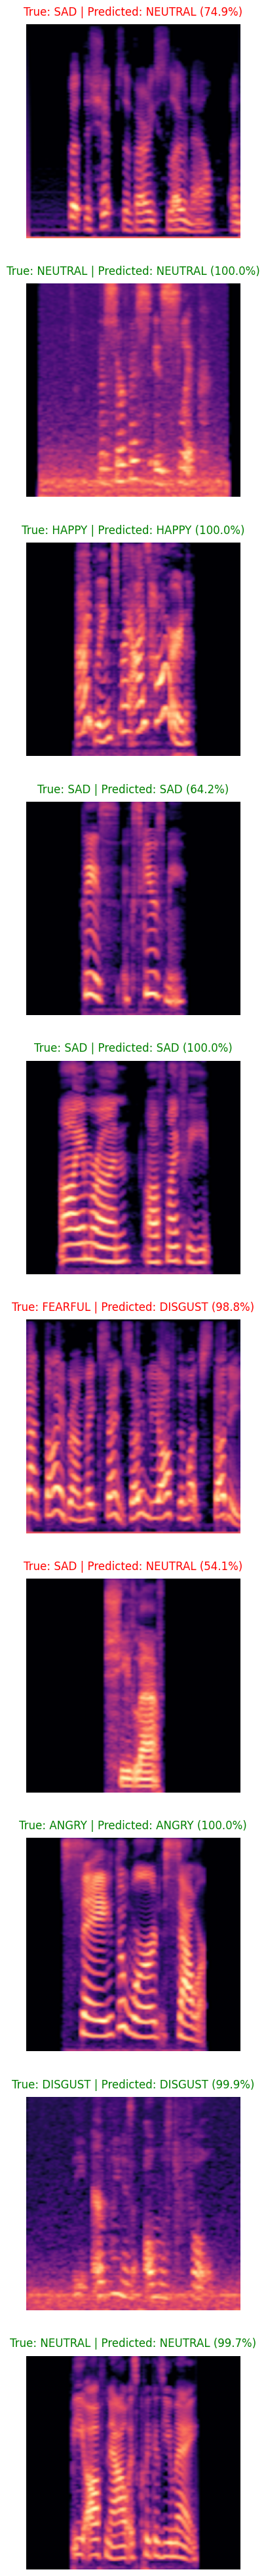


Accuracy on these 10 random samples: 70.0%

Detailed Prediction Probabilities:
------------------------------------------------------------

File: ESD_sad_16869.png
True emotion: SAD
Predictions:
       SAD:  100.0%
     HAPPY:    0.0%
   NEUTRAL:    0.0%
   FEARFUL:    0.0%
  SURPRISE:    0.0%
     ANGRY:    0.0%
   DISGUST:    0.0%
------------------------------------------------------------

File: ESD_surprise_17379.png
True emotion: SURPRISE
Predictions:
  SURPRISE:   89.6%
     HAPPY:   10.3%
     ANGRY:    0.0%
   FEARFUL:    0.0%
   DISGUST:    0.0%
       SAD:    0.0%
   NEUTRAL:    0.0%
------------------------------------------------------------

File: ESD_angry_5362.png
True emotion: ANGRY
Predictions:
     ANGRY:  100.0%
  SURPRISE:    0.0%
     HAPPY:    0.0%
   NEUTRAL:    0.0%
   DISGUST:    0.0%
       SAD:    0.0%
   FEARFUL:    0.0%
------------------------------------------------------------

File: ESD_neutral_9475.png
True emotion: NEUTRAL
Predictions:
     ANGRY: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random

def visualize_test_predictions(test_files, test_labels, model, emotion_map, num_samples=10):
    """
    Visualize spectrograms with true and predicted labels for random test samples.

    Parameters:
    test_files: list of test file paths
    test_labels: list of one-hot encoded true labels
    model: trained model
    emotion_map: dictionary mapping emotions to indices
    num_samples: number of samples to visualize (default=10)
    """

    # Create reverse emotion map for label lookup
    reverse_emotion_map = {v: k for k, v in emotion_map.items()}

    # Randomly select samples
    indices = random.sample(range(len(test_files)), num_samples)

    # Create a figure with num_samples rows and 1 column
    fig = plt.figure(figsize=(12, 4*num_samples))

    for idx, sample_idx in enumerate(indices):
        # Get the image path and true label
        img_path = test_files[sample_idx]
        true_label_idx = np.argmax(test_labels[sample_idx])
        true_emotion = reverse_emotion_map[true_label_idx]

        # Load and preprocess the image
        img = Image.open(img_path).convert("RGB").resize((224, 224))
        img_array = np.array(img) / 255.0

        # Get model prediction
        prediction = model.predict(np.expand_dims(img_array, axis=0), verbose=0)
        pred_label_idx = np.argmax(prediction)
        pred_emotion = reverse_emotion_map[pred_label_idx]
        pred_confidence = prediction[0][pred_label_idx] * 100

        # Create subplot
        ax = plt.subplot(num_samples, 1, idx + 1)

        # Display the spectrogram
        plt.imshow(img_array)
        plt.axis('off')

        # Set title with true and predicted labels
        title_color = 'green' if true_label_idx == pred_label_idx else 'red'
        plt.title(f'True: {true_emotion.upper()} | Predicted: {pred_emotion.upper()} ({pred_confidence:.1f}%)',
                 color=title_color, pad=10)

    plt.tight_layout(pad=3.0)
    plt.show()

    # Print accuracy for these samples
    correct = sum(1 for i in indices if np.argmax(test_labels[i]) ==
                 np.argmax(model.predict(np.expand_dims(np.array(Image.open(test_files[i])
                 .convert("RGB").resize((224, 224))) / 255.0, axis=0), verbose=0)))
    print(f"\nAccuracy on these {num_samples} random samples: {(correct/num_samples)*100:.1f}%")

def print_prediction_probabilities(test_files, test_labels, model, emotion_map, num_samples=10):
    """
    Print detailed prediction probabilities for random test samples.

    Parameters:
    test_files: list of test file paths
    test_labels: list of one-hot encoded true labels
    model: trained model
    emotion_map: dictionary mapping emotions to indices
    num_samples: number of samples to visualize (default=10)
    """
    # Create reverse emotion map for label lookup
    reverse_emotion_map = {v: k for k, v in emotion_map.items()}

    # Randomly select samples
    indices = random.sample(range(len(test_files)), num_samples)

    print("\nDetailed Prediction Probabilities:")
    print("-" * 60)

    for sample_idx in indices:
        # Get the image path and true label
        img_path = test_files[sample_idx]
        true_label_idx = np.argmax(test_labels[sample_idx])
        true_emotion = reverse_emotion_map[true_label_idx]

        # Load and preprocess the image
        img = Image.open(img_path).convert("RGB").resize((224, 224))
        img_array = np.array(img) / 255.0

        # Get model prediction
        prediction = model.predict(np.expand_dims(img_array, axis=0), verbose=0)[0]

        print(f"\nFile: {img_path.split('/')[-1]}")
        print(f"True emotion: {true_emotion.upper()}")
        print("Predictions:")

        # Sort predictions by probability
        sorted_preds = sorted([(reverse_emotion_map[i], prob)
                             for i, prob in enumerate(prediction)],
                            key=lambda x: x[1], reverse=True)

        for emotion, prob in sorted_preds:
            print(f"{emotion.upper():>10}: {prob*100:>6.1f}%")
        print("-" * 60)

# Visualiser les spectrogrammes et les prédictions
visualize_test_predictions(test_files, test_labels, model, emotion_map)

# Afficher les probabilités détaillées
print_prediction_probabilities(test_files, test_labels, model, emotion_map)

In [ ]:
# Save final model
model.save('final_model.keras')